# WGAN with Probabilistic Masks

# 1. Import Libraries

In [29]:
import sys
import os
import random
import numpy as np
import datetime
import shutil
import logging

import torch
import torch.nn as nn
from torch import autograd
from tqdm.auto import tqdm
from torchvision import transforms
# from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
import torchvision.datasets as dset # all datasets available in torch vision. not sure if needed here
import torchvision.utils as vutils # draw bounding box, segmantation mask, keypoints. convert to rgb, make grid, save_image
import torch.optim as optim # optimizer for example optim.Adam([var1, var2], lr=0.0001)

import ignite
import ignite.distributed as idist
from ignite.metrics import FID, InceptionScore

import optuna
from optuna.trial import TrialState
import mlflow

# # data distributed parallelization DDP
# import torch.multiprocessing as mp
# from torch.utils.data.distributed import DistributedSampler
# from torch.nn.parallel import DistributedDataParallel as DDP
# from torch.distributed import init_process_group, destroy_process_group

import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!
import matplotlib.animation as animation
from IPython.display import HTML # to embed html in the Ipython output

sys.path.append("../src/models/")
sys.path.append("../src/utils/")
from GNet64_RGB import OptGen
from DNet64 import OptDis
# from utils import normalizeRGB
from utils import weights_init, postprocess_rgb
from OptimisationFunctions import suggest_hyperparameters, trainModel, test, objective, gradient_penalty

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Set the Params

In [21]:
cadastralRoot = '../../cadastralExportRGB1Img' # Root directory for cadastral images
workers = 2 # Number of workers for dataloader
batch_size = 64 # Batch size during training
image_size = 64 # Spatial size of training images. All images will be resized to this
nc = 3 # Number of channels in the training images. For color images this is 3
nz = 2**4*8*8 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 10 # Number of training epochs
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
lambda_gradient_penality = 0.2 # to adjust the Wasserstein distance with interpolation between real and fake data
ngpu = torch.cuda.device_count() # Number of GPUs available. Use 0 for CPU mode.
experiment = 'RGB64'
trials = 20

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter("%(asctime)s:%(levelname)s:%(message)s")
file_handler = logging.FileHandler('../reports/07_WGAN_RGB.log')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# 3. Prepare Dataloader

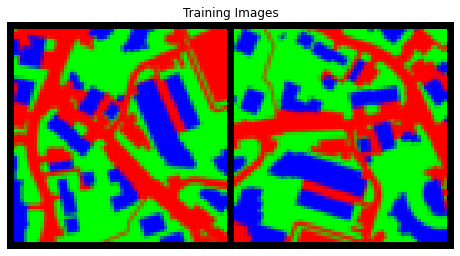

In [4]:
# We can use an image folder dataset the way we have it setup
if os.path.exists(cadastralRoot + '/.ipynb_checkpoints'):
    shutil.rmtree(cadastralRoot + '/.ipynb_checkpoints')

Cad_dataset = dset.ImageFolder(root=cadastralRoot,
                           transform=transforms.Compose([
                               transforms.RandomRotation(degrees=(0,180), expand = False),
                               transforms.CenterCrop(image_size * 10),
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), -> 
                           ]))
# Create the dataloader
Cad_dataloader = torch.utils.data.DataLoader(Cad_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
Cad_real_batch = next(iter(Cad_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(Cad_real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

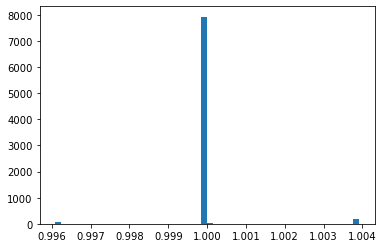

In [5]:
xr = Cad_real_batch[0]
plt.hist(xr.sum(1).flatten().tolist(), bins = 50);

In [6]:
print(f'size: {xr.size()}')
i = random.sample(range(2), 1)[0]

print(f'Percentage of R pixels: {xr[i][0].sum() * 100 / (xr.size(2) * xr.size(3))} %')
print(f'Percentage of G pixels: {xr[i][1].sum() * 100 / (xr.size(2) * xr.size(3))} %')
print(f'Percentage of B pixels: {xr[i][2].sum() * 100 / (xr.size(2) * xr.size(3))} %')

size: torch.Size([2, 3, 64, 64])
Percentage of R pixels: 35.14112091064453 %
Percentage of G pixels: 42.49243927001953 %
Percentage of B pixels: 22.372760772705078 %


# 4. Load Generator

In [7]:
netG = OptGen(ngpu=ngpu, num_conv_layers=3, drop_conv2=0.4).to(device)
netG.apply(weights_init)
print(netG)

OptGen(
  (main): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(16, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (4): DropOut_2): Dropout2d(p=0.4, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (8): Softmax(dim=1)
  )
)


In [8]:
%%time
x = torch.rand((nz)).to(device)
pred = netG.forward(x)

CPU times: user 993 ms, sys: 746 ms, total: 1.74 s
Wall time: 1.76 s


In [9]:
pred.size()

torch.Size([1, 3, 64, 64])

# 5. Load Discriminator

In [10]:
netD = OptDis(ngpu=ngpu, num_conv_layers=3).to(device)
netD.apply(weights_init)
print(netD)

OptDis(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (3): BatchNorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU_2): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Flatten): Flatten(start_dim=1, end_dim=-1)
    (Fully Connected 1): Linear(in_features=16384, out_features=512, bias=True)
    (ReLU): ReLU(inplace=True)
    (Fully Connected 2): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [11]:
xr = Cad_real_batch[0].to(device)

In [12]:
%%time
pred = netD(xr)

CPU times: user 2.74 ms, sys: 7.38 ms, total: 10.1 ms
Wall time: 26.7 ms


In [13]:
pred.size()

torch.Size([2, 1])

# 6. Training

In [14]:
# logging
loggerRGB = logging.getLogger('loggerRGB')
loggerRGB.setLevel(logging.DEBUG)
file_handler = logging.FileHandler('../reports/WGAN_CadastralRGB64.log')
file_handler.setFormatter(formatter)
loggerRGB.addHandler(file_handler)

In [25]:
# %%time

fixed_noise = torch.randn(batch_size, nz, 1, 1).to(device)
torch.manual_seed(23)
np.random.seed(23)

path_trnD = '../models/' + experiment + '_NetD_Training'
path_endD = '../models/' + experiment + '_NetD_Trained'
path_trnG = '../models/' + experiment + '_NetG_Training'
path_endG = '../models/' + experiment + '_NetG_Trained'

if os.path.isfile(path_endD):
    print(f'loading trained DNet from {path_endD}')
    netD = torch.load(path_endD)
elif os.path.isfile(path_trnD):
    print(f'loading trained DNet from {path_trnD}')
    netD = torch.load(path_trnD)
else:
    print(f'Create a new DNet, weights initialized')
    netD = OptDis(ngpu=ngpu, num_conv_layers=3)
    netD.apply(weights_init)

if os.path.isfile(path_endG):
    print(f'loading trained GNet from {path_endG}')
    netG = torch.load(path_endG)
elif os.path.isfile(path_trnG):
    print(f'loading trained GNet from {path_trnG}')
    netG = torch.load(path_trnG)
else:
    print(f'Create a new GNet, weights initialized')
    netG = OptGen(ngpu=ngpu, num_conv_layers=4, drop_conv2=0.4)
    netG.apply(weights_init)

# If more devices are available
if torch.cuda.device_count() > 1:
    netG = nn.DataParallel(netG)
    netD = nn.DataParallel(netD)

netG.to(device)
netD.to(device)

optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

### imgs= trainModel(netG, netD, device, Cad_dataloader_greyscale, 
###                  optimizerG, optimizerD, epochs=10, nz=nz, fixed_noise=fixed_noise, 
###                  folder='../', logger=loggerGreyscale)

imgs = trainModel(netG = netG, netD = netD, device = device, dataloader = Cad_dataloader, 
                 optimizerG = optimizerG, optimizerD = optimizerD, fixed_noise=fixed_noise, 
                 folder='../', epochs=100, nz=nz, experiment = experiment, 
                 AlternativeTraining = 10, logger=loggerRGB)

Create a new DNet, weights initialized
Create a new GNet, weights initialized
Epoch: 0/100 | D Learn: False | D Loss: 0.2087| ErrDReal: -0.008 | ErrDFake: 0.0176 | GradPenality: 0.1991 | G Loss: -0.0052
Epoch: 10/100 | D Learn: True | D Loss: -0.1944| ErrDReal: -0.4412 | ErrDFake: 0.0481 | GradPenality: 0.1987 | G Loss: 0.0226
Epoch: 20/100 | D Learn: False | D Loss: -4.3341| ErrDReal: -4.6182 | ErrDFake: 0.0882 | GradPenality: 0.1959 | G Loss: 0.2711
Epoch: 30/100 | D Learn: True | D Loss: -6.0966| ErrDReal: -6.2488 | ErrDFake: -0.0431 | GradPenality: 0.1953 | G Loss: 0.527
Epoch: 40/100 | D Learn: False | D Loss: -23.1899| ErrDReal: -20.7299 | ErrDFake: -2.6426 | GradPenality: 0.1825 | G Loss: 2.3364
Epoch: 50/100 | D Learn: True | D Loss: -22.7397| ErrDReal: -18.019 | ErrDFake: -4.8997 | GradPenality: 0.179 | G Loss: 2.2063
Epoch: 60/100 | D Learn: False | D Loss: -89.2259| ErrDReal: -75.1214 | ErrDFake: -14.2602 | GradPenality: 0.1557 | G Loss: 18.7402
Epoch: 70/100 | D Learn: True

In [25]:
%%time

fixed_noise = torch.randn(batch_size, nz, 1, 1).to(device)
torch.manual_seed(23)
np.random.seed(23)

# netD = OptDis(ngpu=ngpu, num_conv_layers=3)
# netD.apply(weights_init)
# 
# netG = OptGen(ngpu=ngpu, num_conv_layers=4, drop_conv2=0.4)
# netG.apply(weights_init)

# If more devices are available
if torch.cuda.device_count() > 1:
    netG = nn.DataParallel(netG)
    netD = nn.DataParallel(netD)

netG.to(device)
netD.to(device)

optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

imgs = trainModel(netG = netG, netD = netD, device = device, dataloader = Cad_dataloader, 
                 optimizerG = optimizerG, optimizerD = optimizerD, fixed_noise=fixed_noise, 
                 folder='../', epochs=1000, nz=nz, experiment = experiment, 
                 AlternativeTraining = 10, logger=loggerRGB)

Epoch: 0/1000 | D Learn: False | D Loss: -484524.6875| ErrDReal: 80096.9609 | ErrDFake: -973952.5 | GradPenality: 409330.875 | G Loss: 991491.375
Epoch: 10/1000 | D Learn: True | D Loss: -394418.5312| ErrDReal: 80044.8281 | ErrDFake: -930602.75 | GradPenality: 456139.4062 | G Loss: 951113.125
Epoch: 20/1000 | D Learn: False | D Loss: -440943.7812| ErrDReal: 125744.3828 | ErrDFake: -991440.375 | GradPenality: 424752.2188 | G Loss: 1010016.375
Epoch: 30/1000 | D Learn: True | D Loss: -319875.8438| ErrDReal: 154542.2188 | ErrDFake: -900053.5 | GradPenality: 425635.4062 | G Loss: 996058.0625
Epoch: 40/1000 | D Learn: False | D Loss: -405635.4688| ErrDReal: 169384.9062 | ErrDFake: -1019876.75 | GradPenality: 444856.4062 | G Loss: 879949.8125
Epoch: 50/1000 | D Learn: True | D Loss: -354871.5| ErrDReal: 167475.5 | ErrDFake: -944017.0625 | GradPenality: 421670.0625 | G Loss: 910402.5
Epoch: 60/1000 | D Learn: False | D Loss: -384469.4375| ErrDReal: 168059.4688 | ErrDFake: -973688.6875 | GradP

# 7. Run Optuna to find the best params

In [27]:
nz

1024

In [30]:
run_tag = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

experiment_id = mlflow.create_experiment(
    f"../../reports/WGAN_RGB64_{run_tag}",
    tags={"version": "v1", "priority": "P1"},
)

mlflow.set_experiment(experiment_id=experiment_id)
study = optuna.create_study(study_name=f"WGAN_RGB64_{run_tag}", direction="minimize")

func = lambda trial: objective(trial, nz = nz, dataloader=Cad_dataloader, 
                               n_epochs = 1250, folder = '../', 
                               experiment='WGANRGB', AlternativeTraining = 30, 
                               logger = loggerRGB)
study.optimize(func, n_trials=trials)

[I 2023-06-21 18:52:56,643] A new study created in memory with name: WGAN_RGB64_2023-06-21T18:52:52


OptGen(
  (main): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(16, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): DropOut_2): Dropout2d(p=0.2, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (8): DropOut_3): Dropout2d(p=0.2, inplace=False)
    (9): BatchNorm_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU_3): ReLU(inplace=True)
    (11): TransConv_4): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (12): Softmax(dim=1)
  )
)
Convol

[I 2023-06-21 19:01:22,862] Trial 0 finished with value: 0.27895188331604004 and parameters: {'lr': 0.00019960453106367902, 'dropoutG': 0.2, 'convsG': 4, 'convsD': 3}. Best is trial 0 with value: 0.27895188331604004.


OptGen(
  (main): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(16, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): DropOut_2): Dropout2d(p=0.2, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (8): DropOut_3): Dropout2d(p=0.2, inplace=False)
    (9): BatchNorm_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU_3): ReLU(inplace=True)
    (11): TransConv_4): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (12): Softmax(dim=1)
  )
)
Convol

[I 2023-06-21 19:10:11,298] Trial 1 finished with value: 0.20697680115699768 and parameters: {'lr': 0.00011616199420770327, 'dropoutG': 0.2, 'convsG': 4, 'convsD': 4}. Best is trial 1 with value: 0.20697680115699768.


OptGen(
  (main): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(16, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (5): BatchNorm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (7): Softmax(dim=1)
  )
)
Convolutions for D: 4 | Convolutions for G: 3 | LrRate: 0.0003 | Dropout G: 0.0
Epoch: 0/1250 | D Learn: False | D Loss: 0.1816| ErrDReal: -0.0401 | ErrDFake: 0.0254 | GradPenality: 0.1962 | G Loss: 7.404
Epoch: 10/1250 | D Learn: False | D Loss: -6.3452| ErrDReal: 0.2867 | ErrDFake: -6.8249 | GradPenality: 0.193 | G Loss: 6.8249
Epoch: 20/1250 | D Learn: False | D 

[I 2023-06-21 19:19:03,795] Trial 2 finished with value: 0.23250055313110352 and parameters: {'lr': 0.0002629842708517125, 'dropoutG': 0.0, 'convsG': 3, 'convsD': 4}. Best is trial 1 with value: 0.20697680115699768.


OptGen(
  (main): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(16, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (4): DropOut_2): Dropout2d(p=0.1, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (8): Softmax(dim=1)
  )
)
Convolutions for D: 4 | Convolutions for G: 3 | LrRate: 0.0002 | Dropout G: 0.1
Epoch: 0/1250 | D Learn: False | D Loss: 0.1795| ErrDReal: -0.0401 | ErrDFake: 0.0234 | GradPenality: 0.1962 | G Loss: 5.0534
Epoch: 10/1250 | D Learn: False | D Loss: -4.4138| ErrDReal: 0.2183 | ErrDFake: -4.8266 | GradPenality: 0.194

[I 2023-06-21 19:27:51,308] Trial 3 finished with value: 0.20302371680736542 and parameters: {'lr': 0.0001623083981599092, 'dropoutG': 0.1, 'convsG': 3, 'convsD': 4}. Best is trial 3 with value: 0.20302371680736542.


OptGen(
  (main): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(16, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (4): DropOut_2): Dropout2d(p=0.2, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (8): Softmax(dim=1)
  )
)
Convolutions for D: 4 | Convolutions for G: 3 | LrRate: 0.0001 | Dropout G: 0.2
Epoch: 0/1250 | D Learn: False | D Loss: 0.1656| ErrDReal: -0.0401 | ErrDFake: 0.0096 | GradPenality: 0.1961 | G Loss: 4.1519
Epoch: 10/1250 | D Learn: False | D Loss: -3.6641| ErrDReal: 0.1697 | ErrDFake: -4.0288 | GradPenality: 0.195

[I 2023-06-21 19:36:34,490] Trial 4 finished with value: 0.21824133396148682 and parameters: {'lr': 0.00012336672967197402, 'dropoutG': 0.2, 'convsG': 3, 'convsD': 4}. Best is trial 3 with value: 0.20302371680736542.


OptGen(
  (main): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(16, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (4): DropOut_2): Dropout2d(p=0.2, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (8): Softmax(dim=1)
  )
)
Convolutions for D: 4 | Convolutions for G: 3 | LrRate: 0.0001 | Dropout G: 0.2
Epoch: 0/1250 | D Learn: False | D Loss: 0.1656| ErrDReal: -0.0401 | ErrDFake: 0.0096 | GradPenality: 0.1961 | G Loss: 3.873
Epoch: 10/1250 | D Learn: False | D Loss: -3.4176| ErrDReal: 0.1516 | ErrDFake: -3.7643 | GradPenality: 0.1951

[I 2023-06-21 19:45:22,655] Trial 5 finished with value: 0.21348462998867035 and parameters: {'lr': 0.00011184937485416354, 'dropoutG': 0.2, 'convsG': 3, 'convsD': 4}. Best is trial 3 with value: 0.20302371680736542.


OptGen(
  (main): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(16, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): DropOut_2): Dropout2d(p=0.2, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (8): DropOut_3): Dropout2d(p=0.2, inplace=False)
    (9): BatchNorm_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU_3): ReLU(inplace=True)
    (11): TransConv_4): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (12): Softmax(dim=1)
  )
)
Convol

[I 2023-06-21 19:54:09,356] Trial 6 finished with value: 0.21608476340770721 and parameters: {'lr': 0.000236221837085532, 'dropoutG': 0.2, 'convsG': 4, 'convsD': 4}. Best is trial 3 with value: 0.20302371680736542.


OptGen(
  (main): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(16, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (4): DropOut_2): Dropout2d(p=0.2, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (8): Softmax(dim=1)
  )
)
Convolutions for D: 4 | Convolutions for G: 3 | LrRate: 0.0001 | Dropout G: 0.2
Epoch: 0/1250 | D Learn: False | D Loss: 0.1656| ErrDReal: -0.0401 | ErrDFake: 0.0096 | GradPenality: 0.1961 | G Loss: 2.8514
Epoch: 10/1250 | D Learn: False | D Loss: -2.5094| ErrDReal: 0.0836 | ErrDFake: -2.7885 | GradPenality: 0.195

[W 2023-06-21 19:56:00,515] Trial 7 failed with parameters: {'lr': 7.088021499653262e-05, 'dropoutG': 0.2, 'convsG': 3, 'convsD': 4} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_3140193/3016293549.py", line 11, in <lambda>
    func = lambda trial: objective(trial, nz = nz, dataloader=Cad_dataloader,
  File "/home/furio/SyntheticCities/notebooks/../src/utils/OptimisationFunctions.py", line 272, in objective
    img_list = trainModel(netG = netG, netD = netD, device = device, dataloader = dataloader,
  File "/home/furio/SyntheticCities/notebooks/../src/utils/OptimisationFunctions.py", line 130, in trainModel
    for i, data in enumerate(dataloader, 0):
  File "/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 634, in __next__
    data = self._next_data()
  F

KeyboardInterrupt: 

# ARCHIVE

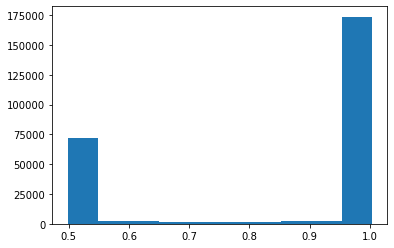

In [123]:
plt.hist(Cad_real_batch[0].sum(1).flatten().tolist());

In [38]:
img = Cad_real_batch[0][0]
img.size()

torch.Size([3, 64, 64])

In [42]:
img = postprocess_rgb(img)

In [30]:
img = img.permute(1,2,0)
img.size()

torch.Size([64, 64, 3])

In [32]:
img

tensor([[[1.0000, 0.0000, 0.0000],
         [0.8941, 0.0000, 0.1059],
         [0.9922, 0.0000, 0.0078],
         ...,
         [0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 1.0000]],

        [[0.0353, 0.0000, 0.9647],
         [0.1882, 0.0000, 0.8118],
         [0.4588, 0.0118, 0.5176],
         ...,
         [0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 1.0000]],

        [[0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 1.0000],
         [0.0039, 0.0039, 0.9922],
         ...,
         [0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 1.0000]],

        ...,

        [[0.0000, 0.5020, 0.0000],
         [0.0000, 0.5020, 0.0000],
         [0.0000, 0.5020, 0.0000],
         ...,
         [1.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000]],

        [[0.0000, 0.5020, 0.0000],
         [0.0000, 0.5020, 0.0000],
         [0.

In [33]:
x, y = 0, 1
pixel = img[x][y].tolist()
pixel

[0.8941176533699036, 0.0, 0.10588235408067703]

In [34]:
i = pixel.index(max(pixel))
i

0

In [35]:
img[x][y][0:3] = 0
img[x][y][i] = 1
img[x][y]

tensor([1., 0., 0.])

In [36]:
img

tensor([[[1.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000],
         [0.9922, 0.0000, 0.0078],
         ...,
         [0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 1.0000]],

        [[0.0353, 0.0000, 0.9647],
         [0.1882, 0.0000, 0.8118],
         [0.4588, 0.0118, 0.5176],
         ...,
         [0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 1.0000]],

        [[0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 1.0000],
         [0.0039, 0.0039, 0.9922],
         ...,
         [0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 1.0000]],

        ...,

        [[0.0000, 0.5020, 0.0000],
         [0.0000, 0.5020, 0.0000],
         [0.0000, 0.5020, 0.0000],
         ...,
         [1.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000]],

        [[0.0000, 0.5020, 0.0000],
         [0.0000, 0.5020, 0.0000],
         [0.

In [54]:
imgFld = '../../cadastralExportRGB/cadastralRGB/'
# dataroot = "../../png/train"

In [55]:
from os import listdir
from os.path import isfile, join
from PIL import Image
import torchvision.transforms.functional as TF
onlyfiles = [imgFld+f for f in listdir(imgFld) if isfile(join(imgFld, f))]
len(onlyfiles)

972

In [63]:
i = 0
x = Image.open(onlyfiles[i])
x = TF.to_tensor(x)
x.size()

torch.Size([4, 1280, 1280])

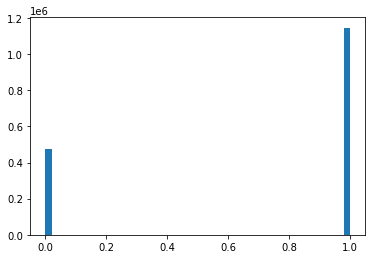

In [81]:
plt.hist(x[0].flatten().tolist(), bins = 50); # {roads}

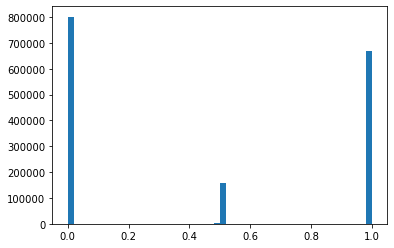

In [80]:
plt.hist(x[1].flatten().tolist(), bins = 50); # green

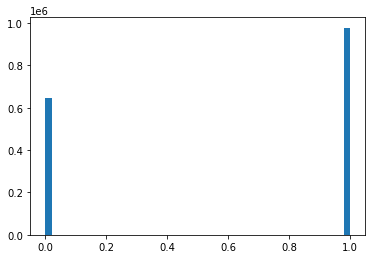

In [82]:
plt.hist(x[2].flatten().tolist(), bins = 50); # buildings

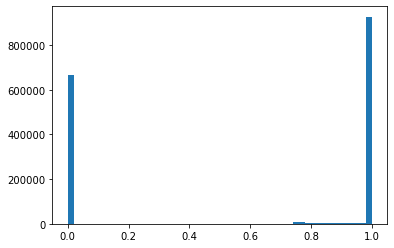

In [68]:
plt.hist(x[3].flatten().tolist(), bins = 50);

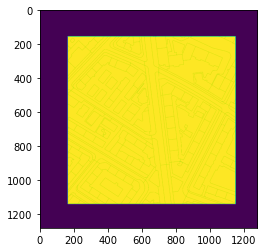

In [84]:
# plt.imshow(x[3].permute(1,2,0)) # alpha
plt.imshow(x[3]);

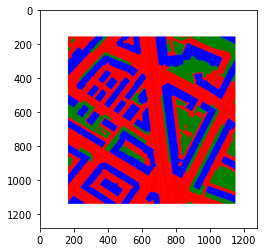

In [112]:
i = 0
x = Image.open(onlyfiles[i])
x = TF.to_tensor(x)
plt.imshow(x.permute(1,2,0));

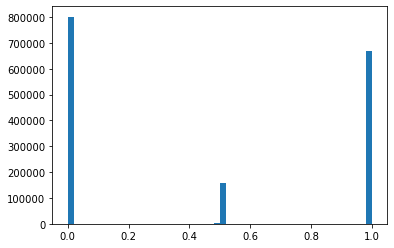

In [106]:
plt.hist(x[1].flatten().tolist(), bins = 50); # green

In [114]:
%%time
x = x[0:3] # remove alpha layer
x = x.permute(1,2,0)
print(f'xsize after permutation: {x.size()}')
for c in range(x.size(0)):
    for r in range(x.size(1)):
        i = x[c][r][:].tolist().index(max(x[c][r]))
        x[c][r][0:3] = 0
        x[c][r][i] = 1
x = x.permute(2,0,1)
print(f'xsize after threshold operation: {x.size()}')

xsize after permutation: torch.Size([1280, 1280, 3])
xsize after threshold operation: torch.Size([3, 1280, 1280])
CPU times: user 1min 14s, sys: 0 ns, total: 1min 14s
Wall time: 1min 14s


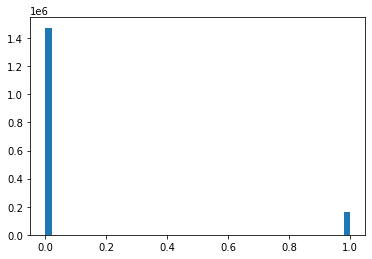

In [115]:
plt.hist(x[1].flatten().tolist(), bins = 50); # green

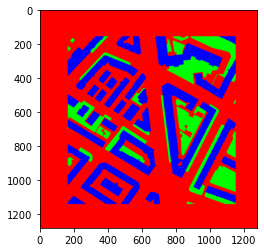

In [116]:
plt.imshow(x.permute(1,2,0));

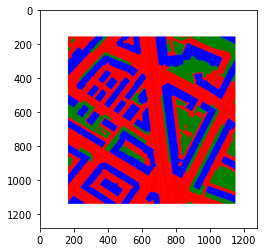

In [130]:
i = 0
x = Image.open(onlyfiles[i])
x = TF.to_tensor(x)
plt.imshow(x.permute(1,2,0));

In [131]:
%%time
x = postprocess_rgb(x[0:3])

CPU times: user 27.9 s, sys: 0 ns, total: 27.9 s
Wall time: 27.9 s


In [132]:
x.size()

torch.Size([1280, 1280, 3])

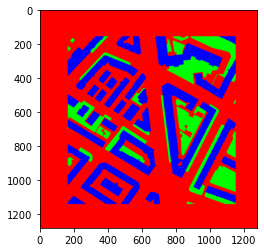

In [133]:
plt.imshow(x);

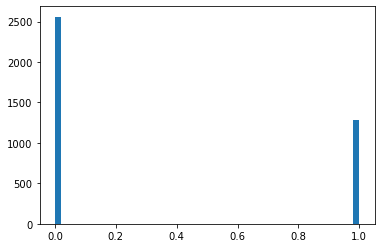

In [134]:
plt.hist(x[1].flatten().tolist(), bins = 50); # green

In [136]:
x.sum(2).flatten().tolist()

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [ ]:
plt.hist(x[1].flatten().tolist(), bins = 50); # green

In [137]:
x = x.permute(2, 0,1)

In [138]:
x.size()

torch.Size([3, 1280, 1280])

In [139]:
onlyfiles[i]

'../../cadastralExportRGB/cadastralRGB/CadastralX2681244Y1247895S250.png'

In [140]:
save_image(x, '../../cadastralExportRGB/cadastralRGB/TEST_CadastralX2681244Y1247895S250.png')

In [142]:
y = Image.open('../../cadastralExportRGB/cadastralRGB/TEST_CadastralX2681244Y1247895S250.png')
y = TF.to_tensor(y)
y.size()

torch.Size([3, 1280, 1280])

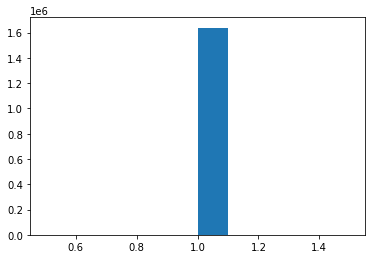

In [143]:
plt.hist(y.sum(0).flatten().tolist());